### Locally-Weighted Conformal Prediction

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [180]:
def mu(x, a, b):
    return a + b*x

def het_sample(n, a, b):
    x = np.random.uniform(-8, 8, n)
    y = mu(x, a, b) + (np.abs(x) + 1) * np.random.randn(n)
    return np.column_stack((x, y))

In [211]:
n_train = 1000
n_cal = 3000
n_test = 3000
n = n_train + n_cal + n_test
alpha = 0.1

a, b, sigma = 1, -1, 3
D = het_sample(n, a, b)

D_train = D[:n_train,:]
D_cal = D[n_train:(n_train + n_cal),:]
D_test = D[(n_train + n_cal):(n_train + n_cal + n_test),:]

X_train = D_train[:, 0]
Y_train = D_train[:, 1]
X_cal = D_cal[:, 0]
Y_cal = D_cal[:, 1]
X_test = D_test[:, 0]
Y_test = D_test[:, 1]

c:\Users\shrey\anaconda3\envs\ml_env\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


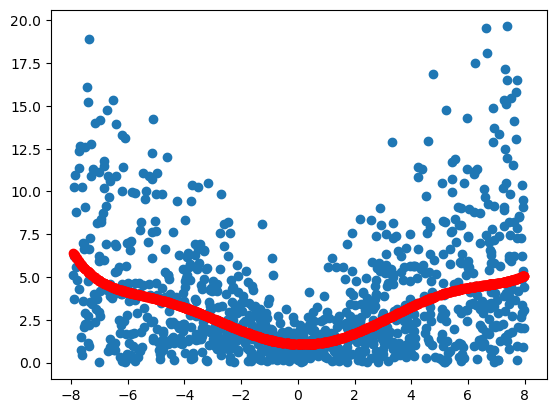

In [214]:
model = LinearRegression()
model.fit(X_train.reshape(-1, 1), Y_train.reshape(-1, 1))

def absolute_residual(x, y, model):
    return np.abs(y - model.predict(x))

abs_errors = absolute_residual(X_train.reshape(-1, 1), Y_train.reshape(-1,1), model)

regressor =  make_pipeline(StandardScaler(), SVR(kernel='poly', degree=6, C=1, coef0=1))

regressor.fit(X_train.reshape(-1, 1), abs_errors)

plt.scatter(X_train, abs_errors)
plt.scatter(X_train, regressor.predict(X_train.reshape(-1,1)), color="red")

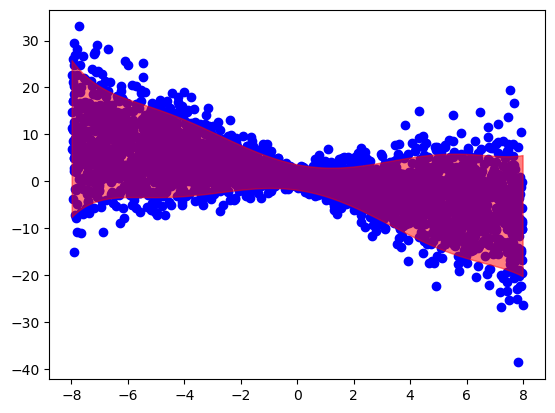

In [215]:
def locally_weighted_score(x, y, mu_model, sigma_model):
    return np.abs(y - mu_model.predict(x).flatten())/sigma_model.predict(x).flatten()
def absolute_residual_score(x, y, model):
    return np.abs(y - model.predict(x))

weighted_scores = locally_weighted_score(X_cal.reshape(-1, 1), Y_cal, model, regressor)
absolute_scores = absolute_residual_score(X_cal.reshape(-1, 1), Y_cal.reshape(-1,1), model)

Y_pred = model.predict(X_test.reshape(-1, 1)).flatten()
sigma_pred = regressor.predict(X_test.reshape(-1,1)).flatten()

q_cal = int(np.ceil((1-alpha)*(n_cal + 1)))
q_weighted = np.sort(weighted_scores.flatten())[q_cal - 1]
q_absolute = np.sort(absolute_scores.flatten())[q_cal - 1]

# x = np.linspace(-8,8,1000)
# y_pred = model.predict(x.reshape(-1,1)).flatten()
# sigma_pred = regressor.predict(x.reshape(-1,1)).flatten()

y_upper = Y_pred + q_weighted * sigma_pred
y_lower = Y_pred - q_weighted * sigma_pred

# y_upper = Y_pred + q_absolute
# y_lower = Y_pred - q_absolute

# plt.plot(x, sigma_pred)

# X_test = X_test[np.where((X_test >= 5) & (X_test <= 6))[0]]
# Y_test = Y_test[np.where((X_test >= 5) & (X_test <= 6))[0]]

plt.scatter(X_test, Y_test, color="blue")

# plt.fill_between(x[np.argsort(x)], y_lower[np.argsort(x)], y_upper[np.argsort(x)], color="red", alpha = 0.5)

plt.fill_between(X_test[np.argsort(X_test)], y_lower[np.argsort(X_test)], y_upper[np.argsort(X_test)], color="red", alpha = 0.5)

In [207]:
def check_coverage(alpha, n, y, y_hat, q_cal, q_hat):
    if q_cal >= n+1:
        return 1
    else:
        return np.mean(np.abs(y-y_hat) <= q_hat)

In [216]:
check_coverage(alpha, n_cal, Y_test, Y_pred, q_cal, q_absolute)

np.float64(0.8993333333333333)

In [107]:
width = 0.2
num = int((16/width)+1)
z = np.linspace(-8, 8, num)

In [108]:
len(np.where((X_test <= z[11]) & (X_test >= z[10]))[0])

19

In [ ]:
def get_local_coverage(z, n, q_cal, q_threshold, X, y, y_hat):
    if q_cal >= n+1:
        return 1
    else:
        local_cov = np.zeros(len(z)-1)
        for i in range(len(z) - 1):
            idx_local = np.where((X <= z[i+1]) & (X >= z[i]))[0]
            y_local = y[idx_local]
            y_hat_local = y_hat[idx_local]

            local_cov[i] = np.mean(np.abs(y_local-y_hat_local) <= q_threshold[idx_local])

    return local_cov

In [217]:
local_cov_weighted = get_local_coverage(z, n_cal, q_cal, q_weighted * sigma_pred, X_test, Y_test, Y_pred)

local_cov_split = get_local_coverage(z, n_cal, q_cal, q_absolute*np.ones(n_test), X_test, Y_test, Y_pred)

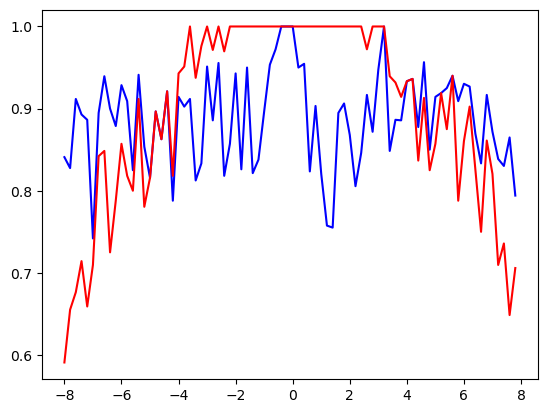

In [218]:
plt.plot(z[:-1], local_cov_weighted, color="blue")
plt.plot(z[:-1], local_cov_split, color="red")